# Maxar Image Availability Analysis

The Maxar image availability workflow takes as input a list of TerraFund project ids and returns as output a csv listing every project and how much of that project’s area has Maxar imagery coverage.

#### Workflow:
1. Pull info on project characteristics for the entire portfolio using the TerraMatch API
    - Repo/notebook: terrafund-portfolio-analysis/tm-api.ipynb
    - Input: list of TerraFund project IDs
    - Output: csv of all project features
2. Using the TM API csv, pull Maxar metadata
    - Repo/notebook: maxar-tools/decision-tree-metadata.ipynb and maxar-tools/src/decision_tree.py (? may need to change b/c of my additions to the acquire_metadata function)
    - Input: csv of project features
    - Output: csv of maxar metadata
3. Calculate the percent area of each project with available Maxar imagery
    - Repo/notebook: terrafund-portfolio-analysis/maxar-img-avail.ipynb and terrafund-portfolio-analysis/src/image_coverage.py
    - Input: csv of maxar metadata and csv of TM project features
    - Output: csv of project features and percent imagery coverage, csv of percent imagery coverage aggregated to project level, csv of polygons with low imagery coverage
4. Identify projects with highest imagery coverage to use for the RS image availability simulation

In [1]:
import pandas as pd
import geopandas as gpd
import sys
sys.path.append('../src/')
import image_coverage as img_cover
import analyze_img_coverage as analyze
from datetime import datetime

### Parameters

In [ ]:
# Naming convention
run_name = 'cohort1'
run_dir = 'tf_cohort1'

# File paths
feats = f'../data/{run_dir}/tm_api_{run_name}_2025-04-01.csv' # CSV of polygon metadata & geometries from TM API (infile)
maxar_md = f'../data/{run_dir}/imagery_availability/comb_img_availability_{run_name}_2025-04-01.csv' # CSV of metadata for Maxar images corresponding to polygons (infile)
results_path = f'../data/{run_dir}/results/baseline/' # File path to save results to

# Define filtering thesholds (stored in a dictionary)
filters = {
    'cloud_cover': 50,          # Remove images with >50% cloud cover
    'off_nadir': 30,            # Remove images with >30° off-nadir angle
    'sun_elevation': 30,        # Keep only images where sun elevation >30°
    'date_range': (-366, 0),    # Date range of 1 year before plantstart
    'img_count': 1,             # Threshold for identifying image availability (REASSESS)
}

### Calculate Image Availability by Project

In [3]:
### 1. LOAD POLYGON AND IMAGE DATA ###
poly_df = pd.read_csv(feats)
img_df = pd.read_csv(maxar_md)

### 2. PREPROCESS POLYGON AND IMAGE DATA ###
poly_gdf = img_cover.preprocess_polygons(poly_df, debug=True)
img_gdf = img_cover.preprocess_images(img_df, debug=True)

### 3. MERGE POLYGON METADATA INTO IMAGE DATA ###
merged_gdf, missing_polygons_list = img_cover.merge_polygons_images(img_gdf, poly_gdf, debug=True)

### 4. FILTER IMAGES ###
img_gdf_filtered = img_cover.filter_images(merged_gdf, filters, debug=True)

### 5. COMPUTE POLYGON-LEVEL IMAGERY COVERAGE ###
# Initialize storage for results & low-coverage polygons list
low_img_coverage_log = []
results = []

# Iterate through all polygons and compute imagery coverage per polygon
for poly_id, project_id in zip(poly_gdf['poly_id'], poly_gdf['project_id']):
    result = img_cover.compute_polygon_image_coverage(poly_id, project_id, poly_gdf, img_gdf_filtered, low_img_coverage_log)
    results.append(result)

# Convert the results to a DataFrame
results_df = pd.DataFrame(results, columns=['poly_id', 'project_id', 'best_image', 'num_images',
                                            'poly_area_ha', 'overlap_area_ha', 'percent_img_cover'])
results_df['best_image'] = results_df['best_image'].fillna("None")

# Convert low-coverage log to DataFrame
#low_coverage_polygons_df = pd.DataFrame(low_img_coverage_log)

### 6. AGGREGATE TO PROJECT-LEVEL COVERAGE ###
project_results_df = img_cover.aggregate_project_image_coverage(results_df, debug=True)

### 7. SAVE RESULTS ###
today = datetime.today().strftime('%Y-%m-%d')

# Percent imagery coverage by polygon
results_df.to_csv(f"{results_path}polygon_imagery_coverage_{run_name}_{today}.csv", index=False)

# Percent imagery coverage by project
project_results_df.to_csv(f"{results_path}project_imagery_coverage_{run_name}_{today}.csv", index=False)

# Polygons with low imagery coverage
if low_img_coverage_log:
    low_coverage_polygons_df = pd.DataFrame(low_img_coverage_log)
    print(f"Logging low image coverage polygons to {results_path}.")
    low_coverage_polygons_df['best_image'] = low_coverage_polygons_df['best_image'].fillna("None")
    low_coverage_polygons_df.to_csv(f"{results_path}low_coverage_polygons_{run_name}_{today}.csv", index=False)

print(f"Imagery coverage results saved to {results_path}")

Processing polygon data...
There are 0 polygons with invalid geometries.
All invalid geometries were fixed successfully.
There are 7 unique polygons for 2 projects in this dataset.
Processing Maxar image data...
There are 137 images for 7 polygons in 2 projects in this dataset.
Merging polygon metadata into image data...
Total images in img_gdf: 137
Total polygons in poly_gdf: 7
Total rows in merged dataset: 137
Unique polygons in merged dataset: 7
There 0 polygons without images in the merged dataset
Polygons without images (dropped at this stage): []
Total images before filtering: 137
Total images after filtering: 28
Polygons with at least one valid image: 7
Computing coverage for polygon 0cf9fc3e-43d5-424d-a998-f66cc34e86b0
Computing coverage for polygon 02faceea-68cb-47c5-b25a-e39771c9e8d9
Logging low coverage for polygon 02faceea-68cb-47c5-b25a-e39771c9e8d9: 7.210444509070234%
Computing coverage for polygon fdfc1a6b-3ab3-4642-b91b-9584d4207cf8
Computing coverage for polygon 2210ca

## Analyze Maxar Image Availability

In [4]:
# Read in files
# Image availability by project
project_img_avail = pd.read_csv(f"{results_path}project_imagery_coverage_{run_name}_{today}.csv")

# Low coverage polygons
low_coverage_poly = pd.read_csv(f"{results_path}low_coverage_polygons_{run_name}_{today}.csv")


📊 Project counts by 10% coverage bins:
 - 0-10%: 0 project(s)
 - 10-20%: 0 project(s)
 - 20-30%: 0 project(s)
 - 30-40%: 0 project(s)
 - 40-50%: 0 project(s)
 - 50-60%: 0 project(s)
 - 60-70%: 0 project(s)
 - 70-80%: 0 project(s)
 - 80-90%: 0 project(s)
 - 90-100%: 2 project(s)


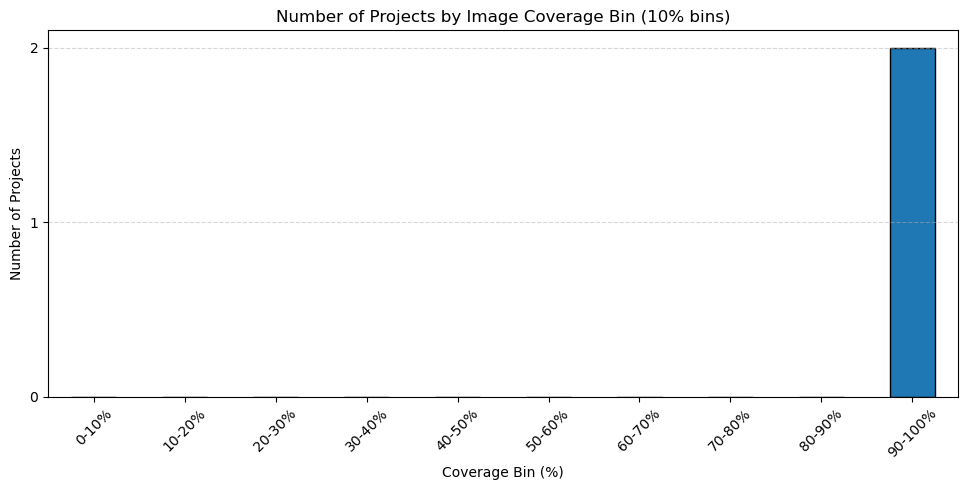

In [5]:
# Overall distribution of image availability
analyze.img_avail_hist(project_img_avail)

In [6]:
# High image availability projects
qualifying_projects_list = analyze.count_projs_wi_img_avail(project_img_avail, 90)


📊 Projects with ≥ 90% image coverage: 2
🆔 Project IDs:
 - 449adf55-f6f8-4f17-97d3-ab6f6bf6676d → 93.77%
 - cf106374-3dd4-401d-80ba-25b70247381a → 100.00%


In [7]:
analyze.analyze_low_coverage_issues(low_coverage_poly)


--- Low Imagery Coverage Analysis ---
📦 Total polygons with low imagery coverage: 1
🛰️ Polygons with at least one image: 1 / 1
📸 Polygons with multiple available images: 1 / 1

📊 Stats for all polygons with images:

🔍 Overlap Area (ha):
count    1.000000
mean     1.820769
std           NaN
min      1.820769
25%      1.820769
50%      1.820769
75%      1.820769
max      1.820769
Name: overlap_area_ha, dtype: float64

🧮 Percent Image Coverage:
count    1.000000
mean     7.210445
std           NaN
min      7.210445
25%      7.210445
50%      7.210445
75%      7.210445
max      7.210445
Name: percent_img_cover, dtype: float64

📊 Stats for polygons with multiple images:

🔍 Overlap Area (ha):
count    1.000000
mean     1.820769
std           NaN
min      1.820769
25%      1.820769
50%      1.820769
75%      1.820769
max      1.820769
Name: overlap_area_ha, dtype: float64

🧮 Percent Image Coverage:
count    1.000000
mean     7.210445
std           NaN
min      7.210445
25%      7.210445
50% 